<a href="https://colab.research.google.com/github/omerhac/arc_challenge/blob/master/board_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install import_ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=973332d2acf7d8b3a5980d14ccb1ada2b8d97ef91598193a2109eba79fda5dd1
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [3]:
# get repository from github
!git clone https://github.com/omerhac/arc_challenge.git

# navigate to dir
%cd arc_challenge

Cloning into 'arc_challenge'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 197 (delta 8), reused 0 (delta 0), pack-reused 179
Receiving objects: 100% (197/197), 10.54 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/arc_challenge


In [4]:
import preprocess

importing Jupyter notebook from preprocess.ipynb


# Data loading and gathering


In [5]:
# load the lists of tasks
training_tasks, eval_tasks, test_tasks = preprocess.load_data_from_jsons()

In [6]:
# augment and arrange the data as an array
all_boards = preprocess.get_all_boards(training_tasks, eval_tasks, test_tasks)
all_boards += preprocess.get_all_boards(training_tasks, eval_tasks, test_tasks) # add another batch of randomly padd boards

# make all boards binary
all_boards = [preprocess.model_shape_board(preprocess.get_binary_board(board)) for board in all_boards]

# get rotated views of all the boards
rotated_boards = []

for board in all_boards:
  rotated_views = preprocess.get_rotated_views(board)
  rotated_boards += rotated_views

# stack
rotated_boards = np.stack(rotated_boards)

In [7]:
print(rotated_boards.shape)

(136320, 16, 16, 1)


# GAN

In [83]:
## constants ##
GENERATOR_DENSE_REP = 64
N_CHANNELS = 1
BOARD_SIZE = [16,16]

# Defining the generator

In [85]:
from tensorflow.keras.layers import Dense, Conv2DTranspose, BatchNormalization, Input
def generator():
  """
  Creates a board generator
  """

  def util_gen(z):
    """
    A utility generator function to be used in a lambda later on
    """

    # project and reshape z
    linear = Dense(256*4*4, activation='linear')(z)
    reshaped_z = tf.keras.layers.Reshape([4, 4, 256])(linear)

    # first deconv layer
    g_conv1 = Conv2DTranspose(128, kernel_size=(3,3), activation='linear')(reshaped_z)
    g_normalized_1 = BatchNormalization(momentum=0.9)(g_conv1)

    # second deconv layer
    g_conv2 = Conv2DTranspose(64, kernel_size=(3,3), activation='linear')(g_normalized_1)
    g_normalized_2 = BatchNormalization(momentum=0.9)(g_conv2)

    # third deconv layer
    g_conv3 = Conv2DTranspose(32, kernel_size=(3,3), activation='linear')(g_normalized_2)
    g_normalized_3 = BatchNormalization(momentum=0.9)(g_conv3)

    # fourth deconv layer
    g_conv4 = Conv2DTranspose(16, kernel_size=(3,3), activation='linear')(g_normalized_3)
    g_normalized_4 = BatchNormalization(momentum=0.9)(g_conv4)

    # fifth deconv layer
    g_conv5 = Conv2DTranspose(8, kernel_size=(3,3), activation='linear')(g_normalized_4)
    g_normalized_5 = BatchNormalization(momentum=0.9)(g_conv5)

    # final layer
    output_board = Conv2DTranspose(1, kernel_size=(3,3), activation='tanh')(g_normalized_5)

    return output_board

  return lambda z: util_gen(z)


## Defining discriminator 

In [86]:
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D
def discriminator():
  """
  Creates a discriminator
  """

  def util_discriminator(board):
    """
    A utility discriminator to be used in a lambda later on
    """

    # first layer
    d_conv1 = Conv2D(8, kernel_size=(3,3), activation='relu', name="d_conv1")(board)
    d_normalized_1 = BatchNormalization(momentum=0.9)(d_conv1)

    # second layer
    d_conv2 = Conv2D(16, kernel_size=(3,3), activation='relu', name="d_conv2")(d_normalized_1)
    d_normalized_2 = BatchNormalization(momentum=0.9)(d_conv2)

    # third layer
    d_conv3 = Conv2D(32, kernel_size=(3,3), activation='relu', name="d_conv3")(d_normalized_2)
    d_normalized_3 = BatchNormalization(momentum=0.9)(d_conv3)

    # fourth layer
    d_conv4 = Conv2D(64, kernel_size=(3,3), activation='relu', name="d_conv4")(d_normalized_3)
    d_normalized_4 = BatchNormalization(momentum=0.9)(d_conv4)

    # dense 1
    dense1 = Dense(512, activation='relu')(d_normalized_4)

    # dense 2
    dense2 = Dense(128, activation='relu')(dense1)

    # output
    d_out = Dense(1, activation='sigmoid')(dense2)

    return d_out
  
  return lambda boards: util_discriminator(boards)

In [87]:
def get_generator():
  z = Input([GENERATOR_DENSE_REP], name='z')
  output = generator()(z)
  
  model = tf.keras.Model(inputs=z, outputs=output)
  return model

def get_discriminator():
  boards = Input([*BOARD_SIZE, 1], name='boards')
  output = discriminator()(boards)
  
  model = tf.keras.Model(inputs=boards, outputs=output)
  return model

In [96]:
g = get_generator()
d = get_discriminator()

In [90]:
g.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               [(None, 64)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 4096)              266240    
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_54 (Conv2DT (None, 6, 6, 128)         295040    
_________________________________________________________________
batch_normalization_83 (Batc (None, 6, 6, 128)         512       
_________________________________________________________________
conv2d_transpose_55 (Conv2DT (None, 8, 8, 64)          73792     
_________________________________________________________________
batch_normalization_84 (Batc (None, 8, 8, 64)          256

# Loss functions

In [94]:
import tensorflow.keras.backend as kb

def discriminator_loss(d_real, d_fake):
  """ 
  discrimintor loss function

  args:
  d_real - decisions on real boards
  d_fake - decisions on fake boards
  """

  real_part = kb.log(d_real)
  fake_part = kb.log(1-d_fake)
 
  # compute loss
  loss = (-1/BATCH_SIZE) * kb.sum(real_part + fake_part)

  return loss

def generator_loss(d_fake):
  """
  generator loss

  args:
  d_fake - discriminator decisions on fake images
  """

  loss = (-1/BATCH_SIZE) * kb.sum(kb.log(d_fake))
  
  return loss

In [97]:
from IPython.display import clear_output

EPOCHS = 1
BATCH_SIZE = 64

# get bum of batches
num_of_batches = rotated_boards.shape[0] // BATCH_SIZE 

# set lists of losses
g_losses, d_losess = [], []

# initate optimizers
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):

  for batch_num in range(num_of_batches):
    
    # open gradient tape
    with tf.GradientTape(persistent=True) as tape: # persistent is needed for drawing gradients twice
      # GENERATE BOARDS
      # generate random dense representations
      rand_dense_reps = np.random.uniform(-1, 1, [BATCH_SIZE, GENERATOR_DENSE_REP]).astype(np.float32)

      # apply generator
      fake_boards = g(rand_dense_reps, training=True)
      
      # DISCRIMINATE
      # batch some real examples
      real_boards = rotated_boards[batch_num*BATCH_SIZE:(batch_num+1)*BATCH_SIZE]

      d_fake = d(fake_boards, training=True) # decesions on fake boards
      d_real = d(real_boards, training=True) # decisions on real boards

      # compute losses
      g_loss = generator_loss(d_fake) # generator loss
      d_loss = discriminator_loss(d_real, d_fake) # discriminator loss 

    # get gradients
    g_grad = tape.gradient(g_loss, g.trainable_weights) # gradient of the generator loss function wrt generator weights
    d_grad = tape.gradient(d_loss, d.trainable_weights) # gradient of discriminator loss function wrt discriminator weights
    
    # TRAIN
    g_optimizer.apply_gradients(zip(g_grad, g.trainable_weights))
    d_optimizer.apply_gradients(zip(d_grad, d.trainable_weights))

    # do some prints
    if batch_num % (num_of_batches // 100) == 1:
      clear_output(wait=True)
      print("{} % done".format(int((batch_num / num_of_batches) * 100))) # batch progress status

      # print losses
      print("generator loss: {}".format(g_loss.numpy())) 
      print("discriminator loss: {}".format(d_loss.numpy())) 

      # append losses
      g_losses.append(g_loss.numpy())
      d_losses.append(d_loss.numpy())



84 % done
generator loss: nan
discriminator loss: nan


KeyboardInterrupt: ignored

In [ ]:
print(d_fake)

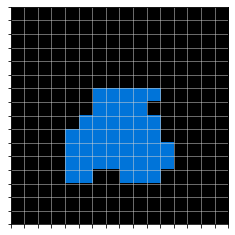

In [82]:
b = preprocess.plotting_shape_board(g(np.random.uniform(-1, 1, [2000, GENERATOR_DENSE_REP]).astype(np.float32)).numpy()[400])
fig, ax = plt.subplots(1,1)
preprocess.plot_board(b, ax)